# **Ice Classification in the Greenland**

# Study Context

* Infrasound is inaudible sound (lower than 20hz) and created when large volumes of air are displaced in the atmosphere.

* It is continuously measured in northwestern Greenland, near
the village of Qaanaaq. The highest number of infrasonic detections were found in recent years from the land-terminating glacier.

* It is concluded that infrasound measurements can help in gaining more insights into glacier dynamics.  

* So, the study emphasizes the correlation between infrasound detection rates and glacier activity. Higher detection rates can indicate increased glacier movement or calving events.

# Setup

# Import libraries

# Read data

In [365]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [366]:
df = pd.read_csv('data_Features.csv')
target = pd.read_csv('data_Targets.csv')

In [367]:
display(df.head())
display(target.head())

,time,t2m,u10,v10,SST,SIC,r1_MAR,r2_MAR,r3_MAR,r4_MAR,r5_MAR
0,2013-01-01,-21.926931,-0.973994,3.149094,-1.690511,90.745710,0.034537,0.033345,0.0,0.0,0.0
1,2013-01-02,-23.696195,-6.502908,2.494894,-1.690511,88.502980,0.034527,0.033326,0.0,0.0,0.0
2,2013-01-03,-25.644027,-3.557411,1.025486,-1.689860,88.734091,0.034523,0.033321,0.0,0.0,0.0
3,2013-01-04,-23.566887,-1.888075,-3.486122,-1.690511,89.149576,0.034509,0.033306,0.0,0.0,0.0
4,2013-01-05,-22.897768,-2.748844,-3.491206,-1.689860,91.613955,0.034492,0.033290,0.0,0.0,0.0


,Unnamed: 0,Y1,Y3,Y4,Y5
0,2013-01-01,0,5,0,0
1,2013-01-02,0,0,0,0
2,2013-01-03,0,0,0,0
3,2013-01-04,0,2,0,0
4,2013-01-05,0,0,0,0


In [368]:
df.shape

(2556, 11)

# Dataset modification based on study

In [370]:
# Rename first column of target dataframe and drop the other target variables as only one given target variable (Y1) will be studied.
target = target.rename(columns={'Unnamed: 0': 'time'})
target = target.drop(columns = ['Y3', 'Y4', 'Y5'])

In [371]:
target.head()

,time,Y1
0,2013-01-01,0
1,2013-01-02,0
2,2013-01-03,0
3,2013-01-04,0
4,2013-01-05,0


In [372]:
# Assign explanatory variable (X) and response variable (y)
X = df.drop(columns = ['time'])
y = target['Y1']

# Dataset examination


In [374]:
def summary(df):
    print(f"Dataset has {df.shape[1] - 1} features and {df.shape[0]} observations.")
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique().values
    summary["Missing"] = df.isnull().sum().values
    summary["Duplicated"] = df.duplicated().sum()
    summary["Types"] = df.dtypes
    return summary

In [375]:
summary(df)

Dataset has 10 features and 2556 observations.


,Unique,Missing,Duplicated,Types
time,2556,0,0,object
t2m,2284,0,0,float64
u10,2372,0,0,float64
v10,2210,0,0,float64
SST,859,0,0,float64
SIC,1774,0,0,float64
r1_MAR,2216,0,0,float64
r2_MAR,2215,0,0,float64
r3_MAR,709,0,0,float64
r4_MAR,754,0,0,float64


Couple $(u10, v10)$ is wind speed.

## Summary statistics of X and y.

In [378]:
X.describe()

,t2m,u10,v10,SST,SIC,r1_MAR,r2_MAR,r3_MAR,r4_MAR,r5_MAR
count,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000
mean,-10.190040,0.139648,0.626351,-0.858922,73.267808,18.789275,11.522362,1.328740,4.382248,5.191286
std,10.340583,5.013640,3.955417,1.446165,29.250724,47.703600,27.942124,3.393452,12.971518,13.406972
min,-32.019122,-13.846656,-12.316128,-1.692462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-19.877500,-3.610168,-2.079422,-1.689860,70.000000,0.123798,0.121437,0.000000,0.000000,0.000000
50%,-9.596479,-0.187084,0.912780,-1.689860,84.601769,0.481870,0.481870,0.000000,0.000000,0.000000
75%,0.167824,3.807440,3.483397,-0.297573,90.362319,4.080174,3.961181,0.004413,0.010148,0.000150
max,7.840619,14.640913,12.811255,6.054536,99.500682,479.722174,281.673389,23.241791,115.876574,88.054318


In [379]:
y.describe()

count    2556.000000
mean        3.525430
std        18.977537
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       433.000000
Name: Y1, dtype: float64

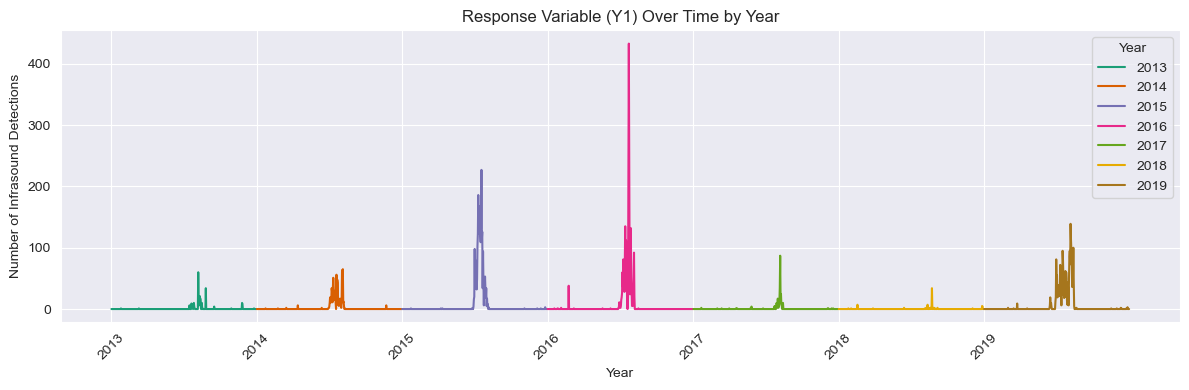

In [380]:
# Convert the 'time' column of target so pandas can recognize it
target['time'] = pd.to_datetime(target['time'])

# Extract year from time
target['year'] = target['time'].dt.year

# Create a new figure with a gray background
plt.figure(figsize=(12, 4))
sns.set_style(style='darkgrid')  # Set gray background with grid

# Define a color palette
colors = sns.color_palette("Dark2", n_colors=target['year'].nunique())  # Get unique colors

# Loop through each year and plot the data
for i, year in enumerate(target['year'].unique()):
    yearly_data = target[target['year'] == year]
    sns.lineplot(x='time', y='Y1', data=yearly_data, color=colors[i], label=str(year))

# Generate years for the x-axis, only keeping the first day of each year (YS for year start)
years = pd.date_range(start='2013-01-01', end='2019-12-31', freq='YS-JAN')
plt.xticks(years, [year.year for year in years], rotation=45)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Number of Infrasound Detections')
plt.title('Response Variable (Y1) Over Time by Year')

# Improve layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.legend(title='Year')
plt.show()

We can observe systematic jumps at the middle of each year. The highest infrasound detection occurs between 2016 and 2017, while the lowest is between 2018 and 2019.

In [382]:
def get_occurrence(Y_true):
    occurrence_dict = {val: Y_true.count(val) for val in set(Y_true)}
    return occurrence_dict

def occurrence_interval(y_true):
    # define intervals and matching labels
    bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 400, float('inf')]
    labels = ['0', '1-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70',
              '70-80', '80-90', '90-100', '100-200', '200-400', '400+']
    # count occurrences in each interval
    counts, _ = np.histogram(y_true, bins=bins)
    # create the dictionary with interval labels (keys) and values
    res = dict(zip(labels, counts))
    return res

def plot_occurrence_pie(plot_dict):
    # Use Seaborn's color palette for styling
    colors = sns.color_palette("Dark2", len(plot_dict))

    # Extract labels and sizes from the dictionary
    labels = list(plot_dict.keys())
    sizes = list(plot_dict.values())

    # Create a pie chart
    plt.figure(figsize=(10, 6))
    wedges, _ = plt.pie(sizes, colors=colors)

    # Create a legend with labels and percentages
    legend_labels = [f"{label}: {size} ({size / sum(sizes) * 100:.2f}%)" for label, size in zip(labels, sizes)]
    plt.legend(wedges, legend_labels, title="Intervals", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.title("Occurrence Target Variable (Y1) by Interval in Percentage (%)")
    plt.show()

In [383]:
# unique attribute for pandas.Series
print(y.unique())

[  0   1   6   9   3  10   4  60  17  21  16  34   8   2  19  12  15  28
  11  35  51  36  23  30  56   7  48  43   5  14  13  63  54  65  20  98
  33  52  79  39  32  49 103 123 186 132 168 119 109 227 113 126  94  42
  45  27  53  18  38  26  81  47  73  84 135  37 112  62 256 433 245  24
  61  29  92  87  55  25  72  44  95  50  57  85 139 114  96  71 100]


In [384]:
occur_dict = get_occurrence(list(y))
y_distinct_val = occur_dict.keys()
print('Distinct values of target variable (Y1):', len(y_distinct_val))

Distinct values of target variable (Y1): 89


In [385]:
occur_interval_dict = occurrence_interval(list(y))
occur_interval_dict

{'0': 2262,
 '1-10': 139,
 '10-20': 40,
 '20-30': 18,
 '30-40': 22,
 '40-50': 12,
 '50-60': 13,
 '60-70': 10,
 '70-80': 6,
 '80-90': 6,
 '90-100': 6,
 '100-200': 18,
 '200-400': 3,
 '400+': 1}

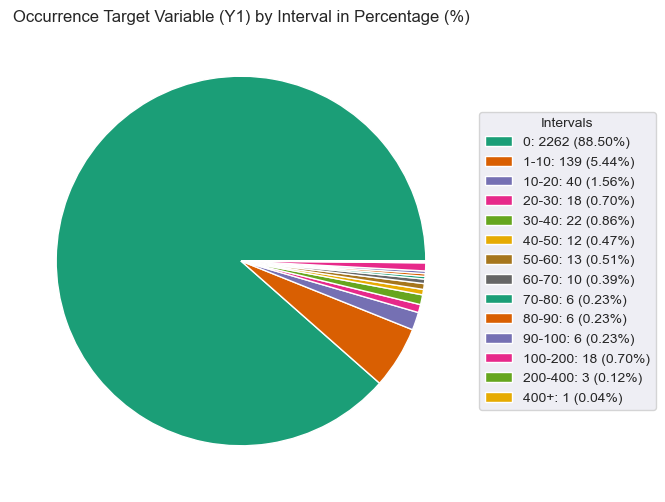

In [386]:
plot_occurrence_pie(occur_interval_dict)

# Encoding

In [388]:
def encode_Y(Y_true):
    res = [0 if ele == 0 else 1 for ele in Y_true]
    return res

In [389]:
# 0 means no infrasound detected
# 1 means infrasound detected
y_new = encode_Y(y)

In [390]:
# get unique value of a list
set(y_new)

{0, 1}

Class 0: 2262
Class 1: 294
Proportion of Class 0: 88.49765258215963
Proportion of Class 1: 11.502347417840369




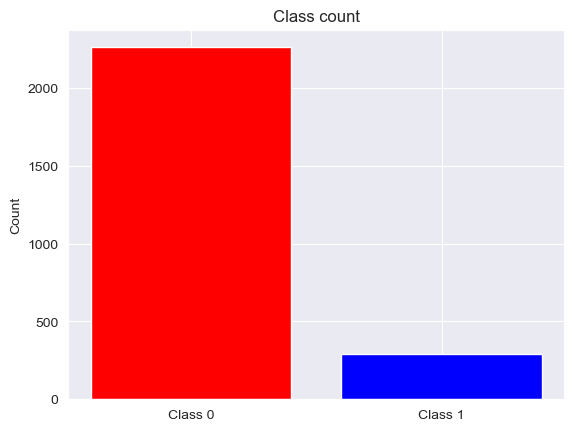

In [391]:
print('Class 0:', y_new.count(0))
print('Class 1:', y_new.count(1))
print('Proportion of Class 0:', (y_new.count(0)/(y_new.count(1)+y_new.count(0)) * 100))
print('Proportion of Class 1:', 100 - (y_new.count(0)/(y_new.count(1)+y_new.count(0)) * 100))
print("\n")
plt.bar(['Class 0', 'Class 1'], [y_new.count(0), y_new.count(1)], color=['red', 'blue'])
plt.title('Class count')
plt.ylabel('Count')
plt.show()

# Define new complete dataframe with encoded y for EDA

In [393]:
# copy from df and append y directly since the time index is already in order
new_df = df.copy()
new_df['y'] = y_new

In [394]:
new_df

,time,t2m,u10,v10,SST,SIC,r1_MAR,r2_MAR,r3_MAR,r4_MAR,r5_MAR,y
0,2013-01-01,-21.926931,-0.973994,3.149094,-1.690511,90.745710,0.034537,0.033345,0.0,0.0,0.0,0
1,2013-01-02,-23.696195,-6.502908,2.494894,-1.690511,88.502980,0.034527,0.033326,0.0,0.0,0.0,0
2,2013-01-03,-25.644027,-3.557411,1.025486,-1.689860,88.734091,0.034523,0.033321,0.0,0.0,0.0,0
3,2013-01-04,-23.566887,-1.888075,-3.486122,-1.690511,89.149576,0.034509,0.033306,0.0,0.0,0.0,0
4,2013-01-05,-22.897768,-2.748844,-3.491206,-1.689860,91.613955,0.034492,0.033290,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2551,2019-12-27,-27.316822,1.597207,-0.091400,-1.689860,95.102792,0.466891,0.462179,0.0,0.0,0.0,1
2552,2019-12-28,-27.998255,3.917396,0.498397,-1.690511,93.949257,0.466818,0.462108,0.0,0.0,0.0,0
2553,2019-12-29,-23.289798,4.664877,2.332191,-1.689860,93.989076,0.417442,0.414464,0.0,0.0,0.0,0
2554,2019-12-30,-25.674814,0.062261,3.760923,-1.689860,94.875746,0.306203,0.306203,0.0,0.0,0.0,0


# Exploratory Data Analysis (EDA)

## Correlation

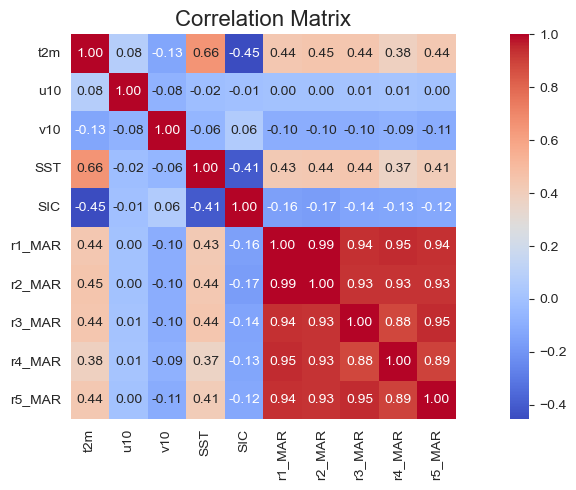

In [397]:
# Calculate the correlation matrix
corr_mat = X.corr()

# Set up plot
plt.figure(figsize=(14, 5))
plt.title('Correlation Matrix', fontsize=16)

# Create a heatmap
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Show the plot
plt.show()

Based on the correlation matrix, we can see that the Greenland liquid water discharge simulated by Region Climate Models for 5 regions (r1_MAR, r2_MAR, r3_MAR, r4_MAR, r5_MAR) are highly correlated. Plus, SST and t2m have a noticeable relation as well.

## Scatter plot (PCA)

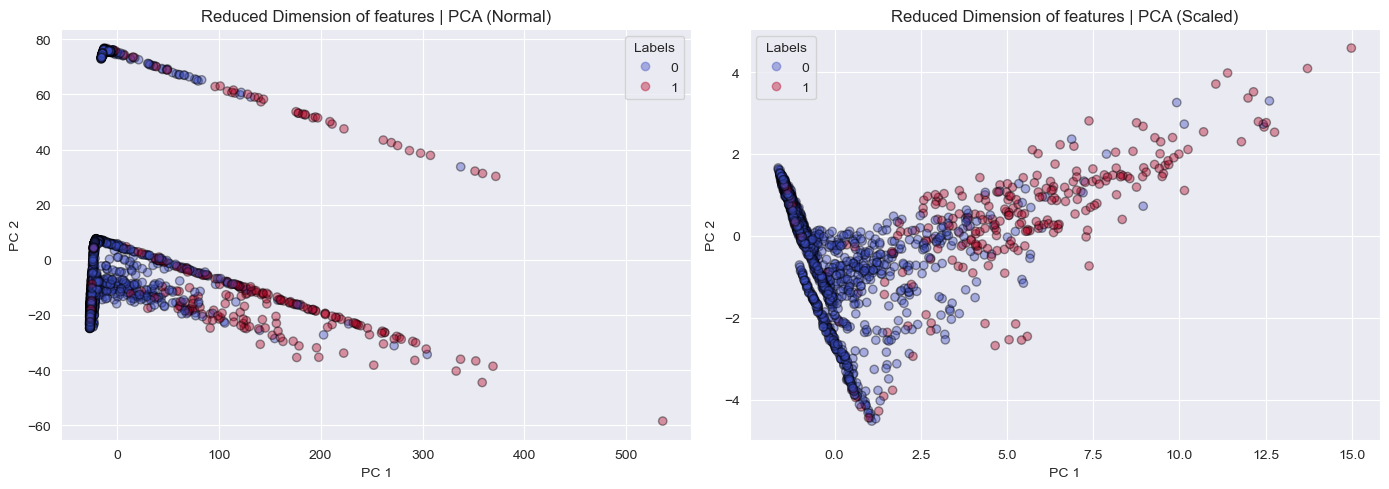

In [400]:
def plot_2d_space_normal(df, ax, title):
    X = df.drop(columns=['time', 'y'])
    y = df['y']

    # Performing PCA
    pca = PCA(n_components=2)  # 2 dimensions
    X_pca = pca.fit_transform(X)

    # Plot on the provided axis
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha = 0.4)  # k = black
    ax.set_title(title)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')

    handles, labels = scatter.legend_elements()
    ax.legend(handles, labels, title="Labels")

def plot_2d_space_scaled(df, ax, title):
    X = df.drop(columns=['time', 'y'])
    y = df['y']

    # Scaling the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Performing PCA on scaled data
    pca = PCA(n_components=2)  # 2 dimensions
    X_pca = pca.fit_transform(X_scaled)

    # Plot on the provided axis
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha = 0.4)  # k = black
    ax.set_title(title)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')

    handles, labels = scatter.legend_elements()
    ax.legend(handles, labels, title="Labels")

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot normal PCA
plot_2d_space_normal(new_df, axs[0], title='Reduced Dimension of features | PCA (Normal)')

# Plot scaled PCA
plot_2d_space_scaled(new_df, axs[1], title='Reduced Dimension of features | PCA (Scaled)')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The distribution of features is not that clear, but we can see that blue points (class 0) are more likely concentrated on the left side. While red points are more narrow to the right, we also can notice the outlier of red point which is the day with 433 infrasound detections.

## Boxplot

In [403]:
def plot_boxplots(df):
  # Drop column time as it is not a feature
  df = df.drop(columns=['time'])
  # Retrieve columns name except Y (the last column)
  features = df.columns[:-1]
  # Setup plot
  plt.figure(figsize=(22, 10))

  for i, feature in enumerate(features):
      # Create a 2x5 grid for 10 plots for 10 different features
      # iterate and plot 1 box at a time
      plt.subplot(2, 5, i + 1)
      sns.set_style("darkgrid")
      # label x-axis as target variable (y), y-axis as each future
      sns.boxplot(x='y', y=feature, data=df, hue='y')
      plt.title(f"Boxplot of {feature} vs y")

  plt.tight_layout()
  plt.show()

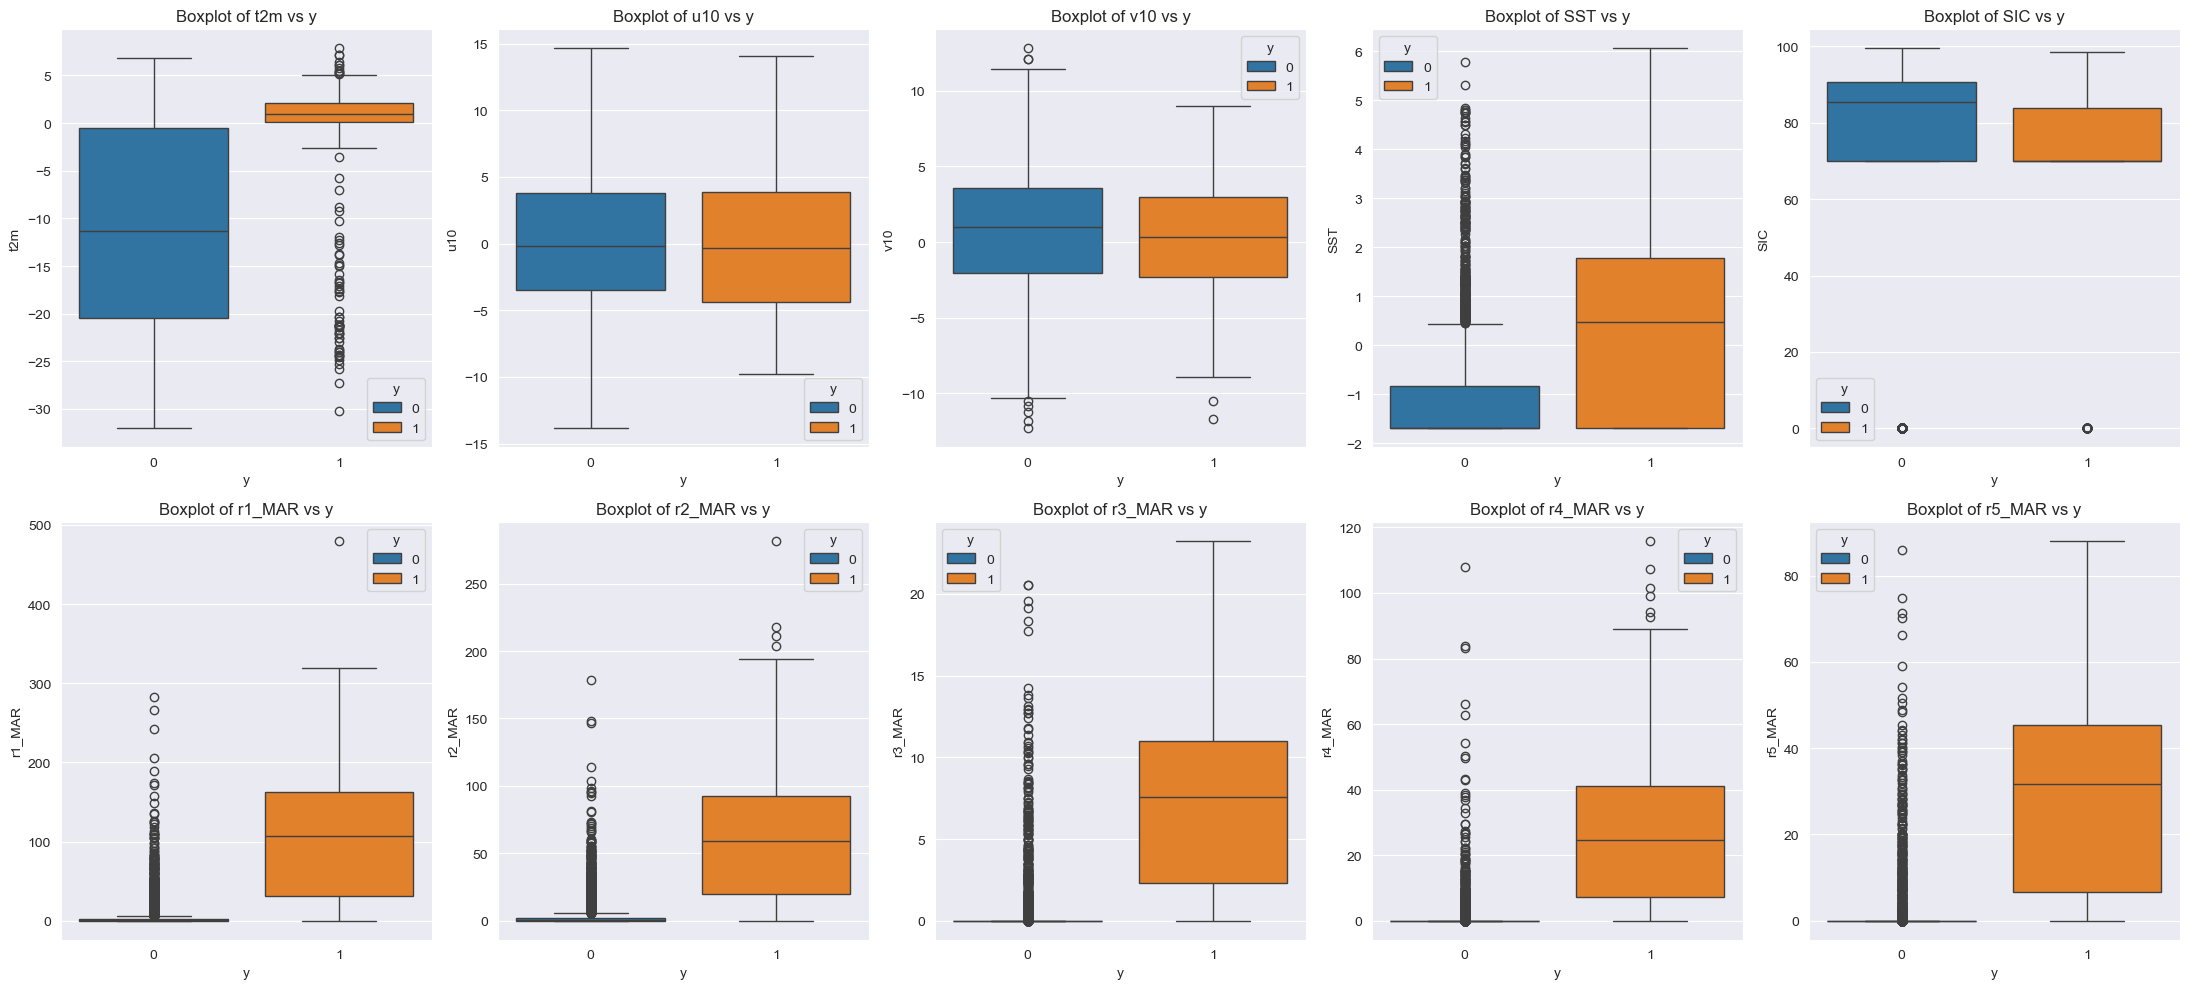

In [404]:
plot_boxplots(new_df)

* Both $u10$ and $v10$ seem to have a similar median and range, with no significant presence of outliers between their own classes 0 and 1, though we can see some outliers for $v10$ and a slightly wider spread of class 0. Hence, they might have less distinguishing power than the others.

* The distributions of $SIC$ for y = 0 and y = 1 are very similar, with similar medians and upper bounds. Also, the presence of low outliers at 0 suggests extreme deviations from typical values in both groups, so SIC does not show a strong distinguishing pattern between the two groups.

* While the others features suggest notable difference which might have a strong saying (informative) for the classification.

* For $r1\_MAR$ to $r5\_MAR$ of class 1, they generally have higher and more varied values, while class 0, are mostly low with occasional high outliers.



## Covariates by class

In [407]:
def plot_features_by_class(df):

    features = df.drop(columns = ['y', 'time'])

    # Setup plot
    plt.figure(figsize=(22, 10))

    for i, feature in enumerate(features):
        # Create a 2x5 grid for 10 plots for 10 different features
        # iterate and plot one KDE at a time
        plt.subplot(2, 5, i + 1)
        sns.set_style("darkgrid")
        # label x-axis as target variable (y), y-axis as each future
        sns.kdeplot(x=feature, data=df, hue='y')
        plt.title(f"Kernel Density Estimate (KDE) plot of {feature} vs y")

    plt.tight_layout()
    plt.show()

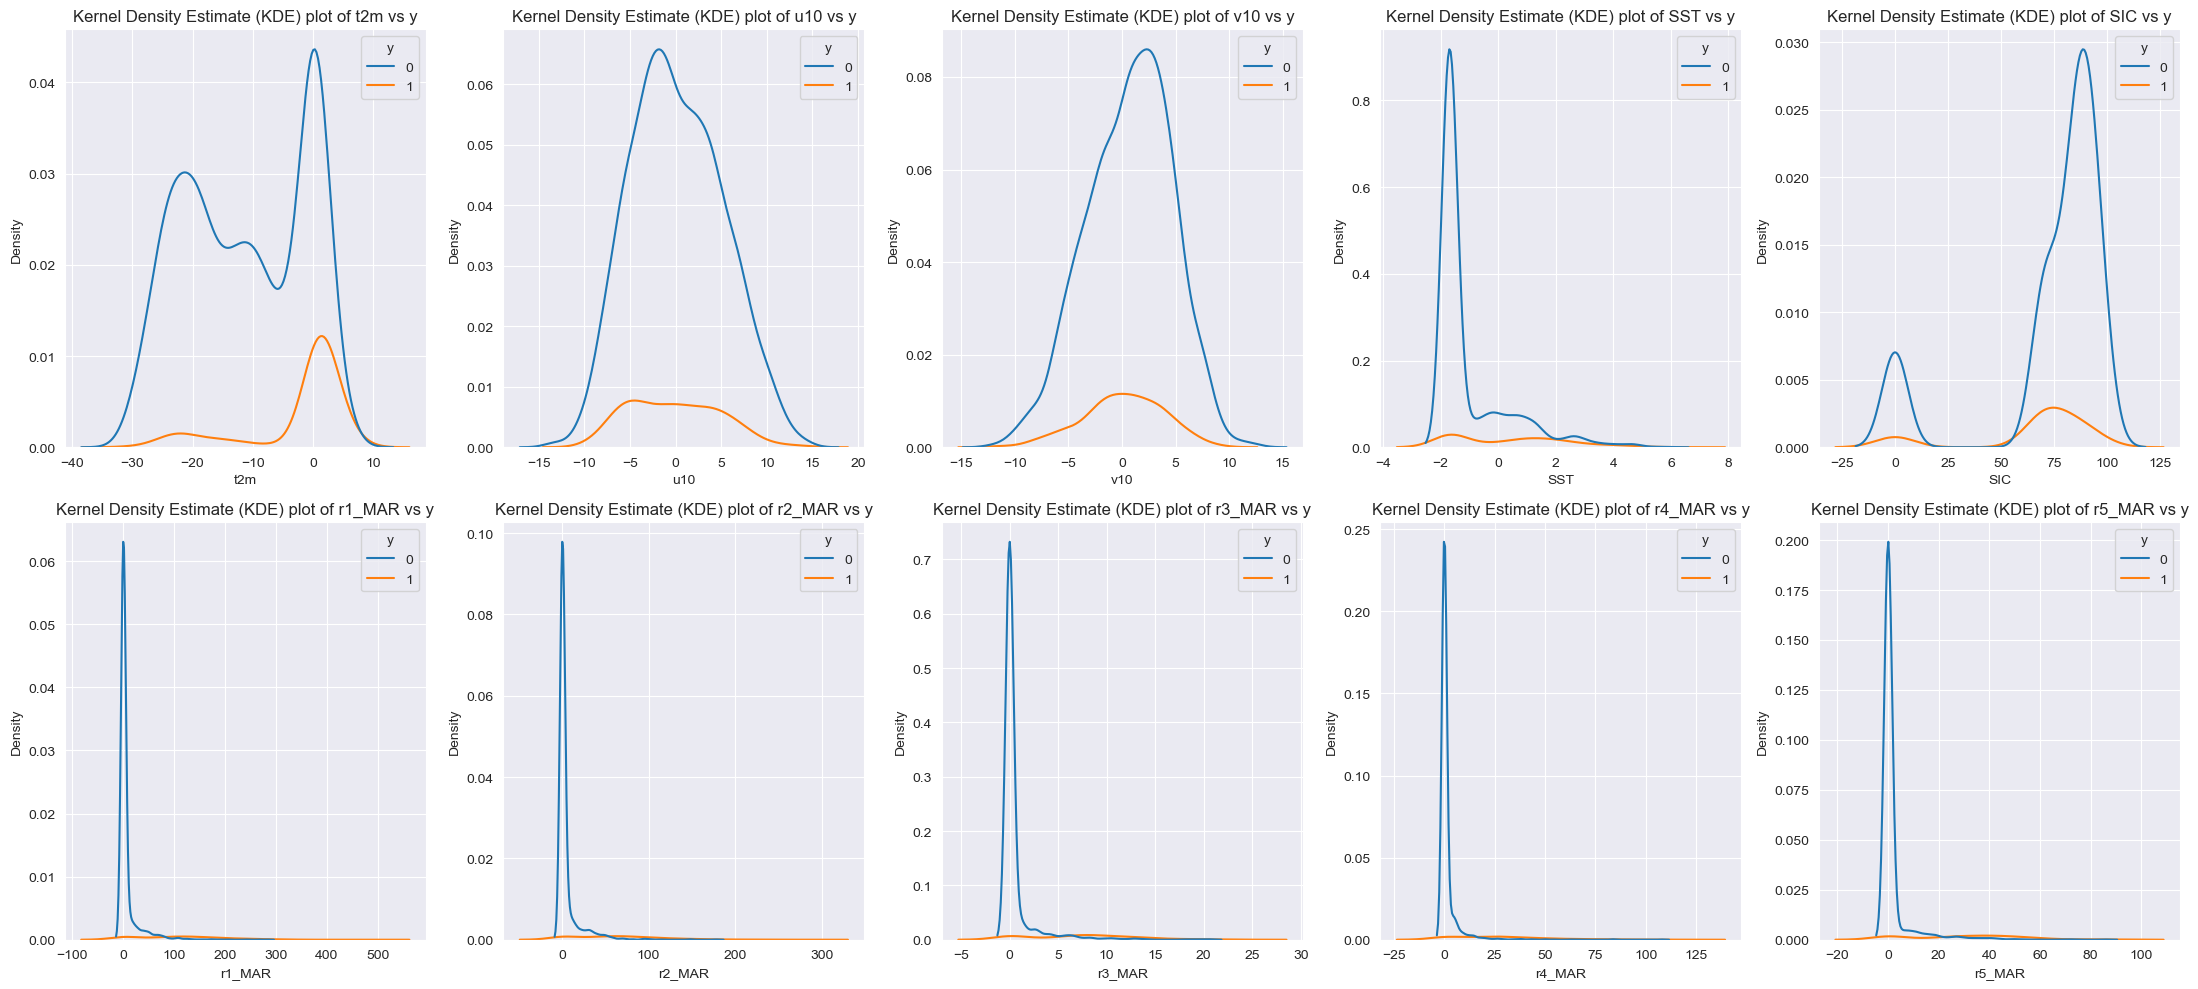

In [408]:
plot_features_by_class(new_df)

* Follow the boxplot, we can see here that for variable $u10$ (same for $v10$ and $SIC$), although the curve of class 0 is higher than 1, it is noticeable that both class 0 and 1 have similar underlying distribution.

* While for the others, we can easily distinguish between class 0 and 1.

# Methodology

In [412]:
def weighted_error(y_obs, y_pred, weight_fp, weight_fn):
    n = len(y_obs)
    sum = 0
    for i in range(n):
        if (y_obs[i] == 0 and y_pred[i] == 1):
            sum += weight_fp
        elif (y_obs[i] == 1 and y_pred[i] == 0):
            sum += weight_fn
    return sum/n

# Experiment



In [414]:
X

,t2m,u10,v10,SST,SIC,r1_MAR,r2_MAR,r3_MAR,r4_MAR,r5_MAR
0,-21.926931,-0.973994,3.149094,-1.690511,90.745710,0.034537,0.033345,0.0,0.0,0.0
1,-23.696195,-6.502908,2.494894,-1.690511,88.502980,0.034527,0.033326,0.0,0.0,0.0
2,-25.644027,-3.557411,1.025486,-1.689860,88.734091,0.034523,0.033321,0.0,0.0,0.0
3,-23.566887,-1.888075,-3.486122,-1.690511,89.149576,0.034509,0.033306,0.0,0.0,0.0
4,-22.897768,-2.748844,-3.491206,-1.689860,91.613955,0.034492,0.033290,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2551,-27.316822,1.597207,-0.091400,-1.689860,95.102792,0.466891,0.462179,0.0,0.0,0.0
2552,-27.998255,3.917396,0.498397,-1.690511,93.949257,0.466818,0.462108,0.0,0.0,0.0
2553,-23.289798,4.664877,2.332191,-1.689860,93.989076,0.417442,0.414464,0.0,0.0,0.0
2554,-25.674814,0.062261,3.760923,-1.689860,94.875746,0.306203,0.306203,0.0,0.0,0.0


In [415]:
df[["year", "month", "day"]] = df["time"].str.split("-", expand=True)
X = df.drop(['time', 'year', 'u10', 'v10'], axis=1)

seed = 123
n_fold = 10

n_models = 7
data = {
    "model": ["Naive Bayes", "Logistic regression", "Decision Tree", "Decision Tree (optimal alpha)", "Random Forest", "AdaBoost", "Stacking"],
    "accuracy": [0.]*n_models,
    "weighted error": [0.]*n_models,
    "AUC": [0.]*n_models
}

MAP = 0.5

index = 0
performance = pd.DataFrame(data)
performance

,model,accuracy,weighted error,AUC
0,Naive Bayes,0.0,0.0,0.0
1,Logistic regression,0.0,0.0,0.0
2,Decision Tree,0.0,0.0,0.0
3,Decision Tree (optimal alpha),0.0,0.0,0.0
4,Random Forest,0.0,0.0,0.0
5,AdaBoost,0.0,0.0,0.0
6,Stacking,0.0,0.0,0.0


## Naive Bayes

Accuracy for every fold : [0.91796875 0.953125   0.91796875 0.90234375 0.90625    0.9140625
 0.9372549  0.9254902  0.93333333 0.9254902 ]
Mean accuracy : 0.9233287377450982
Standard deviation of accuracies : 0.014375556073051224

Confusion Matrix :
[[2144  118]
 [  78  216]] 

Weighted error : 0.19874804381846636 

Area under the Roc Curve (AUC) : 0.8446915017112062


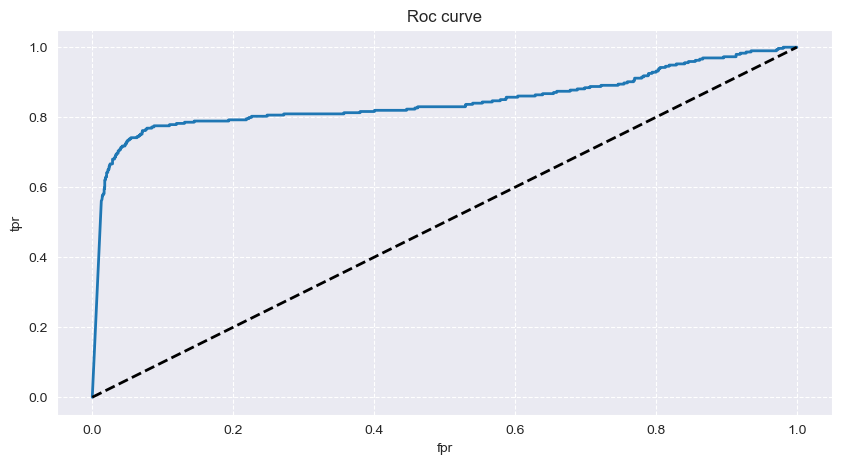

In [417]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()

kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

cv_scores = cross_val_score(NB, X, y_new, cv=kfold, scoring='accuracy')

print(f"Accuracy for every fold : {cv_scores}")
print(f"Mean accuracy : {cv_scores.mean()}")
print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

y_pred_proba = cross_val_predict(NB, X, y_new, cv=kfold, method='predict_proba')
proba = y_pred_proba[:,1] # Probability corrresponding to the class 1 

y_pred = [int(proba[i]>MAP) for i in range(len(proba))]

conf_matrix = confusion_matrix(y_new, y_pred)
print("Confusion Matrix :")
print(conf_matrix, "\n")

werror = weighted_error(y_new, y_pred, 1, 5)
print("Weighted error :", werror, "\n")

fpr, tpr, thresholds= roc_curve(y_new, proba);
auc = roc_auc_score(y_new, proba)
print("Area under the Roc Curve (AUC) :", auc)

figure= plt.figure(figsize=(10,5));
plt.plot(fpr,tpr, linewidth= 2);
plt.title('Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed')
plt.show();

performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
index += 1

## Logistic regression

Accuracy for every fold : [0.9453125  0.95703125 0.92578125 0.9296875  0.94140625 0.93359375
 0.94901961 0.94901961 0.96470588 0.93333333]
Mean accuracy : 0.942889093137255
Standard deviation of accuracies : 0.011848575212920947

Confusion Matrix :
[[2226   36]
 [ 110  184]] 

Weighted error : 0.229264475743349 

Area under the Roc Curve (AUC) : 0.8693648989215492


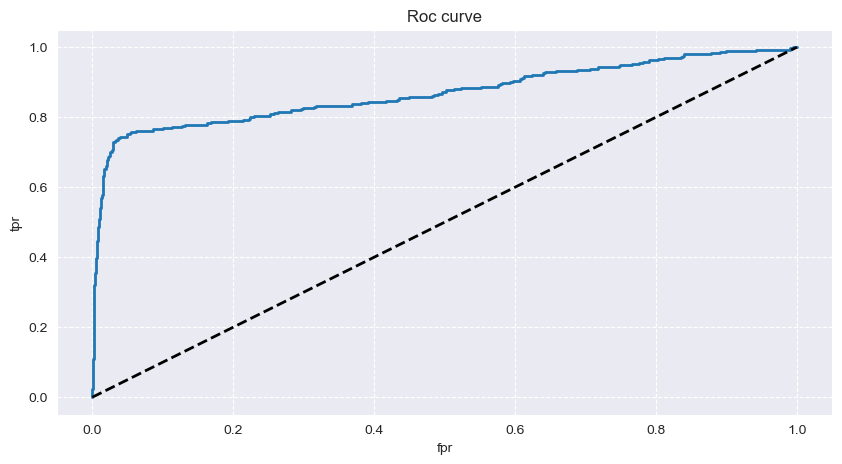

In [419]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)

kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

cv_scores = cross_val_score(logreg, X, y_new, cv=kfold, scoring='accuracy')

print(f"Accuracy for every fold : {cv_scores}")
print(f"Mean accuracy : {cv_scores.mean()}")
print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

y_pred_proba = cross_val_predict(logreg, X, y_new, cv=kfold, method='predict_proba')
proba = y_pred_proba[:,1] # Probability corrresponding to the class 1 

y_pred = [int(proba[i]>MAP) for i in range(len(proba))]

conf_matrix = confusion_matrix(y_new, y_pred)
print("Confusion Matrix :")
print(conf_matrix, "\n")

werror = weighted_error(y_new, y_pred, 1, 5)
print("Weighted error :", werror, "\n")

fpr, tpr, thresholds= roc_curve(y_new, proba);
auc = roc_auc_score(y_new, proba)
print("Area under the Roc Curve (AUC) :", auc)

figure= plt.figure(figsize=(10,5));
plt.plot(fpr,tpr, linewidth= 2);
plt.title('Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed')
plt.show();

performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
index += 1

## Decision Tree


Accuracy for every fold : [0.88671875 0.921875   0.89453125 0.8828125  0.92578125 0.890625
 0.91764706 0.89803922 0.9254902  0.89411765]
Mean accuracy : 0.9037637867647058
Standard deviation of accuracies : 0.016095784262729333

Confusion Matrix :
[[2133  129]
 [ 114  180]] 

Weighted error : 0.2734741784037559 

Area under the Roc Curve (AUC) : 0.7776078601201755


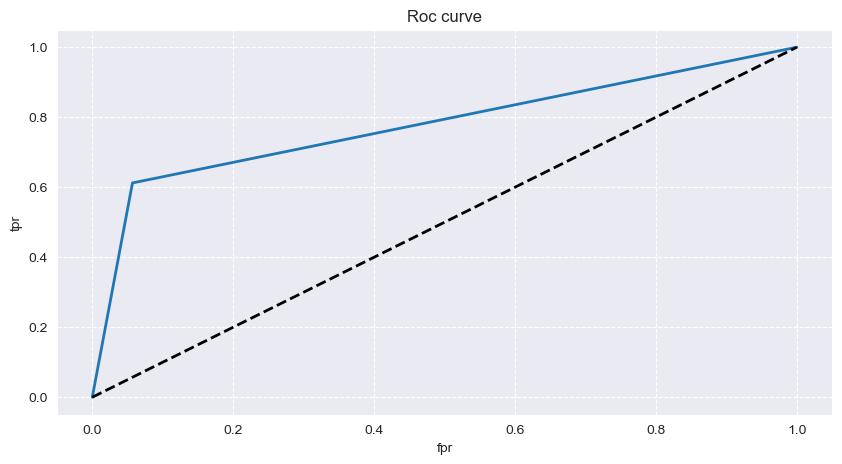

In [421]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

cv_scores = cross_val_score(tree, X, y_new, cv=kfold, scoring='accuracy')

print(f"Accuracy for every fold : {cv_scores}")
print(f"Mean accuracy : {cv_scores.mean()}")
print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

y_pred_proba = cross_val_predict(tree, X, y_new, cv=kfold, method='predict_proba')
proba = y_pred_proba[:,1] # Probability corrresponding to the class 1 

y_pred = [int(proba[i]>MAP) for i in range(len(proba))]

conf_matrix = confusion_matrix(y_new, y_pred)
print("Confusion Matrix :")
print(conf_matrix, "\n")

werror = weighted_error(y_new, y_pred, 1, 5)
print("Weighted error :", werror, "\n")

fpr, tpr, thresholds= roc_curve(y_new, proba);
auc = roc_auc_score(y_new, proba)
print("Area under the Roc Curve (AUC) :", auc)

figure= plt.figure(figsize=(10,5));
plt.plot(fpr,tpr, linewidth= 2);
plt.title('Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed')
plt.show();

performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
index += 1

Optimal alpha : 0.0012559248207253708


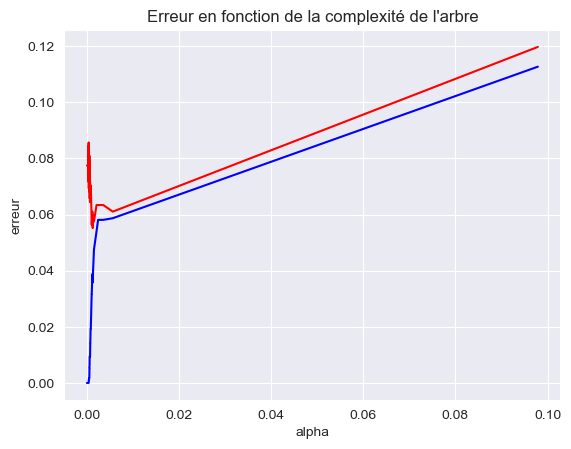

In [422]:
path = tree.cost_complexity_pruning_path(X, y_new)
alphas = path.ccp_alphas
train_errors = []
test_errors = []

X_train, X_test, Y_train, Y_test = train_test_split(X, y_new, test_size = 1/3, random_state = seed)

for i in range(len(alphas)):
    T = DecisionTreeClassifier(ccp_alpha=alphas[i])
    treefit = T.fit(X_train, Y_train)

    pY_train = treefit.predict_proba(X_train)
    predclass = np.argmax(pY_train, axis = 1)

    pY_test = treefit.predict_proba(X_test)
    predclass_test = np.argmax(pY_test, axis = 1)

    #Accuracy
    E_train = (Y_train != predclass).sum() / len(Y_train)
    E_test = (Y_test != predclass_test).sum() / len(Y_test)

    train_errors.append(E_train)
    test_errors.append(E_test)

opt_alpha = alphas[test_errors.index(min(test_errors))]
print("Optimal alpha :", opt_alpha)
plt.figure()
plt.plot(alphas, train_errors, c = "blue")
plt.plot(alphas, test_errors, c= "red")
plt.title("Erreur en fonction de la complexité de l'arbre")
plt.xlabel("alpha")
plt.ylabel("erreur")
plt.show()

Accuracy for every fold : [0.93359375 0.953125   0.9140625  0.92578125 0.9296875  0.91796875
 0.96078431 0.95294118 0.96470588 0.92941176]
Mean accuracy : 0.9382061887254902
Standard deviation of accuracies : 0.017232909100803006

Confusion Matrix :
[[2220   42]
 [ 116  178]] 

Weighted error : 0.2433489827856025 

Area under the Roc Curve (AUC) : 0.8386556656261089


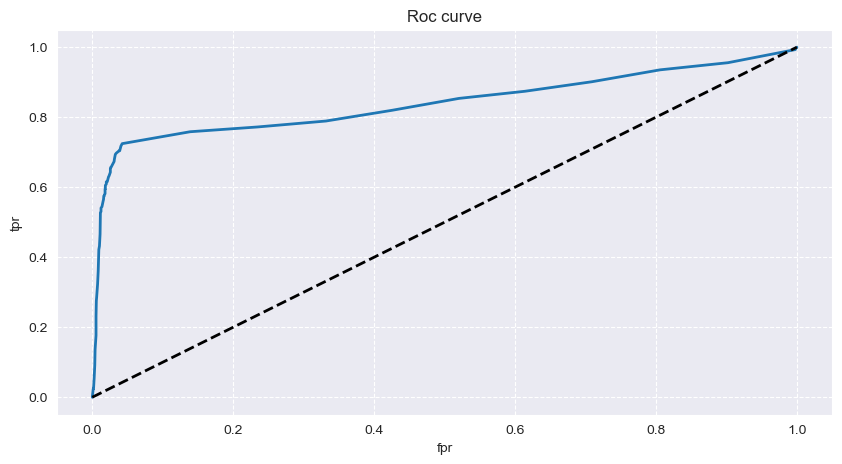

In [423]:
tree = DecisionTreeClassifier(ccp_alpha=opt_alpha)

kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

cv_scores = cross_val_score(tree, X, y_new, cv=kfold, scoring='accuracy')

print(f"Accuracy for every fold : {cv_scores}")
print(f"Mean accuracy : {cv_scores.mean()}")
print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

y_pred_proba = cross_val_predict(tree, X, y_new, cv=kfold, method='predict_proba')
proba = y_pred_proba[:,1] # Probability corrresponding to the class 1 

y_pred = [int(proba[i]>MAP) for i in range(len(proba))]

conf_matrix = confusion_matrix(y_new, y_pred)
print("Confusion Matrix :")
print(conf_matrix, "\n")

werror = weighted_error(y_new, y_pred, 1, 5)
print("Weighted error :", werror, "\n")

fpr, tpr, thresholds= roc_curve(y_new, proba);
auc = roc_auc_score(y_new, proba)
print("Area under the Roc Curve (AUC) :", auc)

figure= plt.figure(figsize=(10,5));
plt.plot(fpr,tpr, linewidth= 2);
plt.title('Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed')
plt.show();

performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
index += 1

## Random Forest

Accuracy for every fold : [0.94140625 0.96875    0.9296875  0.9296875  0.9453125  0.91796875
 0.95294118 0.95294118 0.96862745 0.92941176]
Mean accuracy : 0.9436734068627451
Standard deviation of accuracies : 0.016390499009324083

Confusion Matrix :
[[2220   42]
 [ 102  192]] 

Weighted error : 0.215962441314554 

Area under the Roc Curve (AUC) : 0.8859574333712265


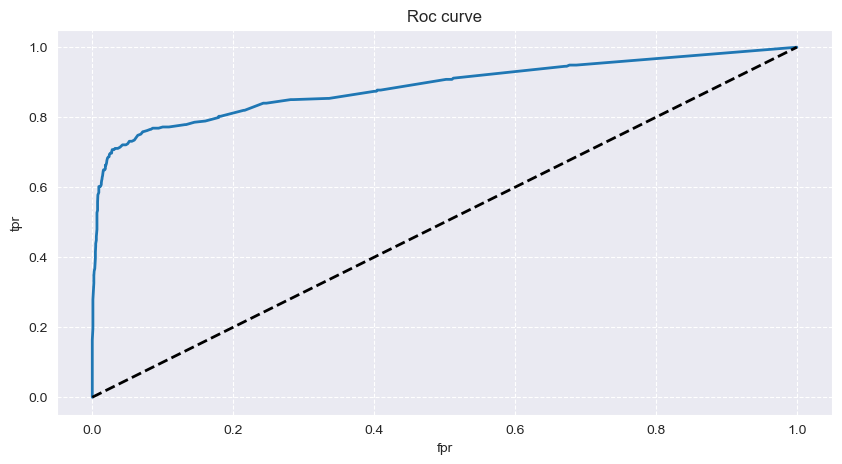

In [425]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100, random_state=seed)

kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

cv_scores = cross_val_score(RF, X, y_new, cv=kfold, scoring='accuracy')

print(f"Accuracy for every fold : {cv_scores}")
print(f"Mean accuracy : {cv_scores.mean()}")
print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

y_pred_proba = cross_val_predict(RF, X, y_new, cv=kfold, method='predict_proba')
proba = y_pred_proba[:,1] # Probability corrresponding to the class 1 

y_pred = [int(proba[i]>MAP) for i in range(len(proba))]

conf_matrix = confusion_matrix(y_new, y_pred)
print("Confusion Matrix :")
print(conf_matrix, "\n")

werror = weighted_error(y_new, y_pred, 1, 5)
print("Weighted error :", werror, "\n")

fpr, tpr, thresholds= roc_curve(y_new, proba);
auc = roc_auc_score(y_new, proba)
print("Area under the Roc Curve (AUC) :", auc)

figure= plt.figure(figsize=(10,5));
plt.plot(fpr,tpr, linewidth= 2);
plt.title('Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed')
plt.show();

performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
index += 1

## AdaBoost

Accuracy for every fold : [0.93359375 0.94921875 0.9296875  0.91796875 0.9296875  0.921875
 0.94509804 0.94901961 0.95686275 0.93333333]
Mean accuracy : 0.9366344975490197
Standard deviation of accuracies : 0.012146959221906107

Confusion Matrix :
[[2213   49]
 [ 113  181]] 

Weighted error : 0.24021909233176839 

Area under the Roc Curve (AUC) : 0.8782006171168733


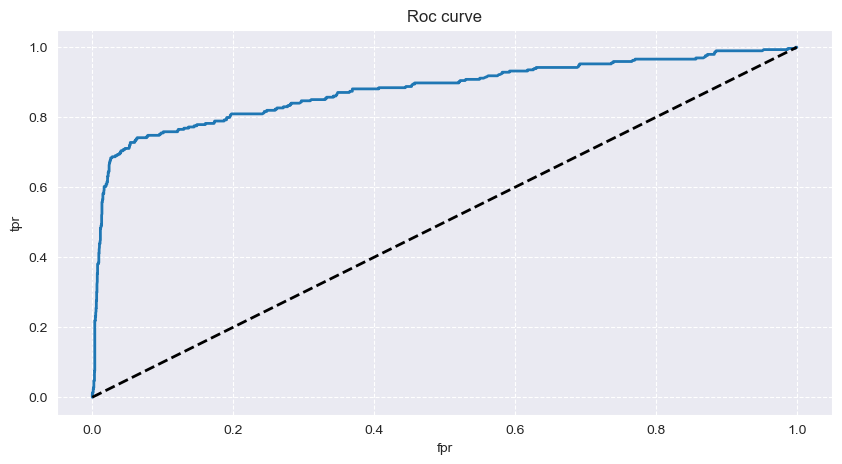

In [427]:
from sklearn.ensemble import AdaBoostClassifier

Ab = AdaBoostClassifier(n_estimators=100, random_state=seed, algorithm="SAMME")

kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

cv_scores = cross_val_score(Ab, X, y_new, cv=kfold, scoring='accuracy')

print(f"Accuracy for every fold : {cv_scores}")
print(f"Mean accuracy : {cv_scores.mean()}")
print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

y_pred_proba = cross_val_predict(Ab, X, y_new, cv=kfold, method='predict_proba')
proba = y_pred_proba[:,1] # Probability corrresponding to the class 1 

y_pred = [int(proba[i]>MAP) for i in range(len(proba))]

conf_matrix = confusion_matrix(y_new, y_pred)
print("Confusion Matrix :")
print(conf_matrix, "\n")

werror = weighted_error(y_new, y_pred, 1, 5)
print("Weighted error :", werror, "\n")

fpr, tpr, thresholds= roc_curve(y_new, proba);
auc = roc_auc_score(y_new, proba)
print("Area under the Roc Curve (AUC) :", auc)

figure= plt.figure(figsize=(10,5));
plt.plot(fpr,tpr, linewidth= 2);
plt.title('Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed')
plt.show();

performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
index += 1

## Stacking

Accuracy pour chaque fold : [0.9453125  0.96484375 0.94921875 0.94921875 0.94140625 0.9296875
 0.9372549  0.92156863 0.94901961 0.94901961]
Accuracy moyen : 0.943655024509804
Écart-type des accuracies : 0.011402175825915652
Confusion Matrix :
[[2217   45]
 [  99  195]] 

Weighted error : 0.2112676056338028 

Area under the Roc Curve (AUC) : 0.866187589093993


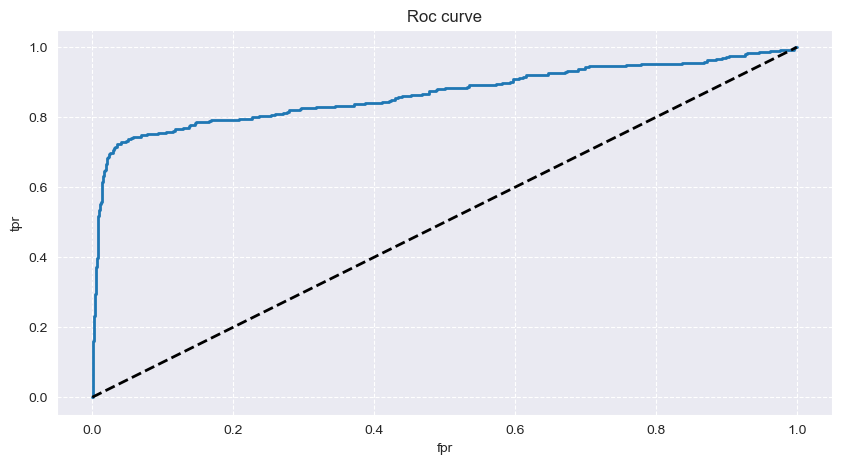

In [429]:
# Import des bibliothèques nécessaires
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Définition des classificateurs de base
base_learners = [
    ('naive_bayes', GaussianNB()),
    ('lda', LDA()),
    ('qda', QDA()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
]

# Définition du modèle méta (stacking) - ici un autre modèle, comme une régression logistique
meta_model = LogisticRegression()

# Création du StackingClassifier avec les classificateurs de base et le modèle méta
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model)

kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

cv_scores = cross_val_score(stacking_model, X, y_new, cv=kfold, scoring='accuracy')

print(f"Accuracy pour chaque fold : {cv_scores}")
print(f"Accuracy moyen : {cv_scores.mean()}")
print(f"Écart-type des accuracies : {cv_scores.std()}")

y_pred_proba = cross_val_predict(stacking_model, X, y_new, cv=kfold, method='predict_proba')
proba = y_pred_proba[:,1] # Probability corrresponding to the class 1 

y_pred = [int(proba[i]>MAP) for i in range(len(proba))]

conf_matrix = confusion_matrix(y_new, y_pred)
print("Confusion Matrix :")
print(conf_matrix, "\n")

werror = weighted_error(y_new, y_pred, 1, 5)
print("Weighted error :", werror, "\n")

fpr, tpr, thresholds= roc_curve(y_new, proba);
auc = roc_auc_score(y_new, proba)
print("Area under the Roc Curve (AUC) :", auc)

figure= plt.figure(figsize=(10,5));
plt.plot(fpr,tpr, linewidth= 2);
plt.title('Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed')
plt.show();

performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
index += 1

# Performance

In [431]:
performance

,model,accuracy,weighted error,AUC
0,Naive Bayes,0.923329,0.198748,0.844692
1,Logistic regression,0.942889,0.229264,0.869365
2,Decision Tree,0.903764,0.273474,0.777608
3,Decision Tree (optimal alpha),0.938206,0.243349,0.838656
4,Random Forest,0.943673,0.215962,0.885957
5,AdaBoost,0.936634,0.240219,0.878201
6,Stacking,0.943655,0.211268,0.866188


In [432]:
# ALL model
def get_perf_table(X, y_new, nb_fold=10, seed=123):
  #init table
  n_models = 6
  data = {
      "model": ["Naive Bayes", "Logistic regression", "Decision Tree", "Decision Tree (optimal alpha)", "Random Forest", "AdaBoost"],
      "accuracy": [0.]*n_models,
      "weighted error": [0.]*n_models,
      "AUC": [0.]*n_models
  }

  index = 0
  performance = pd.DataFrame(data)

  # Naive Bayes
  NB = GaussianNB()

  kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

  cv_scores = cross_val_score(NB, X, y_new, cv=kfold, scoring='accuracy')

  print(f"Accuracy for every fold : {cv_scores}")
  print(f"Mean accuracy : {cv_scores.mean()}")
  print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

  y_pred = cross_val_predict(NB, X, y_new, cv=kfold)

  conf_matrix = confusion_matrix(y_new, y_pred)
  print("Confusion Matrix :")
  print(conf_matrix, "\n")

  werror = weighted_error(y_new, y_pred, 1, 5)
  fpr, tpr, thresholds= roc_curve(y_new, y_pred);
  auc = roc_auc_score(y_new, y_pred)

  performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
  index += 1

  #Logit

  logreg = LogisticRegression(max_iter=1000)

  kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

  cv_scores = cross_val_score(logreg, X, y_new, cv=kfold, scoring='accuracy')

  print(f"Accuracy for every fold : {cv_scores}")
  print(f"Mean accuracy : {cv_scores.mean()}")
  print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

  y_pred = cross_val_predict(logreg, X, y_new, cv=kfold)

  conf_matrix = confusion_matrix(y_new, y_pred)
  print("Confusion Matrix :")
  print(conf_matrix, "\n")

  werror = weighted_error(y_new, y_pred, 1, 5)
  fpr, tpr, thresholds= roc_curve(y_new, y_pred);
  auc = roc_auc_score(y_new, y_pred)

  performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
  index += 1

  #Decision Tree

  tree = DecisionTreeClassifier()

  kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

  cv_scores = cross_val_score(tree, X, y_new, cv=kfold, scoring='accuracy')

  print(f"Accuracy for every fold : {cv_scores}")
  print(f"Mean accuracy : {cv_scores.mean()}")
  print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

  y_pred = cross_val_predict(tree, X, y_new, cv=kfold)

  conf_matrix = confusion_matrix(y_new, y_pred)
  print("Confusion Matrix :")
  print(conf_matrix, "\n")

  werror = weighted_error(y_new, y_pred, 1, 5)
  fpr, tpr, thresholds= roc_curve(y_new, y_pred);
  auc = roc_auc_score(y_new, y_pred)

  performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
  index += 1

  # find opt
  path = tree.cost_complexity_pruning_path(X, y_new)
  alphas = path.ccp_alphas
  train_errors = []
  test_errors = []

  X_train, X_test, Y_train, Y_test = train_test_split(X, y_new, test_size = 1/3, random_state = seed)

  for i in range(len(alphas)):
      T = DecisionTreeClassifier(ccp_alpha=alphas[i])
      treefit = T.fit(X_train, Y_train)

      pY_train = treefit.predict_proba(X_train)
      predclass = np.argmax(pY_train, axis = 1)

      pY_test = treefit.predict_proba(X_test)
      predclass_test = np.argmax(pY_test, axis = 1)

      #Accuracy
      E_train = (Y_train != predclass).sum() / len(Y_train)
      E_test = (Y_test != predclass_test).sum() / len(Y_test)

      train_errors.append(E_train)
      test_errors.append(E_test)

  opt_alpha = alphas[test_errors.index(min(test_errors))]
  print("Optimal alpha :", opt_alpha)

  #opt tree
  tree = DecisionTreeClassifier(ccp_alpha=opt_alpha)

  kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

  cv_scores = cross_val_score(tree, X, y_new, cv=kfold, scoring='accuracy')

  print(f"Accuracy for every fold : {cv_scores}")
  print(f"Mean accuracy : {cv_scores.mean()}")
  print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

  y_pred = cross_val_predict(tree, X, y_new, cv=kfold)

  conf_matrix = confusion_matrix(y_new, y_pred)
  print("Confusion Matrix :")
  print(conf_matrix, "\n")

  werror = weighted_error(y_new, y_pred, 1, 5)
  fpr, tpr, thresholds= roc_curve(y_new, y_pred);
  auc = roc_auc_score(y_new, y_pred)

  performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
  index += 1


  # Forest

  RF = RandomForestClassifier(n_estimators=100, random_state=seed)

  kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

  cv_scores = cross_val_score(RF, X, y_new, cv=kfold, scoring='accuracy')

  print(f"Accuracy for every fold : {cv_scores}")
  print(f"Mean accuracy : {cv_scores.mean()}")
  print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

  y_pred = cross_val_predict(RF, X, y_new, cv=kfold)

  conf_matrix = confusion_matrix(y_new, y_pred)
  print("Confusion Matrix :")
  print(conf_matrix, "\n")

  werror = weighted_error(y_new, y_pred, 1, 5)
  fpr, tpr, thresholds= roc_curve(y_new, y_pred);
  auc = roc_auc_score(y_new, y_pred)

  performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
  index += 1

  #ADA boost

  Ab = AdaBoostClassifier(n_estimators=100, random_state=seed, algorithm="SAMME")

  kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

  cv_scores = cross_val_score(Ab, X, y_new, cv=kfold, scoring='accuracy')

  print(f"Accuracy for every fold : {cv_scores}")
  print(f"Mean accuracy : {cv_scores.mean()}")
  print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

  y_pred = cross_val_predict(Ab, X, y_new, cv=kfold)

  conf_matrix = confusion_matrix(y_new, y_pred)
  print("Confusion Matrix :")
  print(conf_matrix, "\n")

  werror = weighted_error(y_new, y_pred, 1, 5)
  fpr, tpr, thresholds= roc_curve(y_new, y_pred);
  auc = roc_auc_score(y_new, y_pred)

  performance.loc[index , ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]
  index += 1

  return performance

# Resample

## Under-sampling

In [435]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy='auto') #'auto': equivalent to 'not minority'.
X_rus, y_rus = rus.fit_resample(X, y_new)

Random Undersampling dataset: (588, 10)


Class 0: 294
Class 1: 294
Proportion of Class 0: 50.0
Proportion of Class 1: 50.0




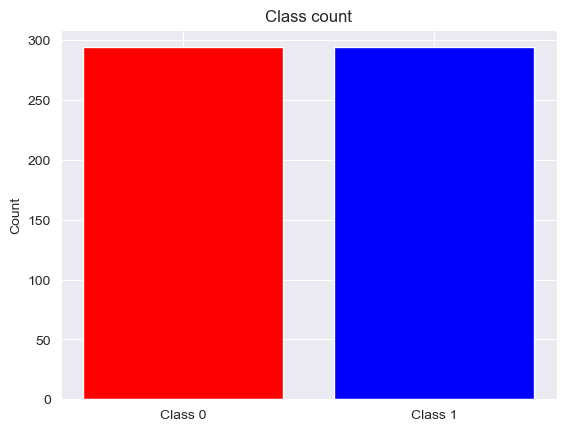

In [436]:
print('Random Undersampling dataset:', X_rus.shape)
print('\n')
print('Class 0:', y_rus.count(0))
print('Class 1:', y_rus.count(1))
print('Proportion of Class 0:', (y_rus.count(0)/(y_rus.count(1)+y_rus.count(0)) * 100))
print('Proportion of Class 1:', 100 - (y_rus.count(0)/(y_rus.count(1)+y_rus.count(0)) * 100))
print("\n")
plt.bar(['Class 0', 'Class 1'], [y_rus.count(0), y_rus.count(1)], color=['red', 'blue'])
plt.title('Class count')
plt.ylabel('Count')
plt.show()

In [437]:
df_rus = X_rus.copy()
df_rus['y'] = y_rus

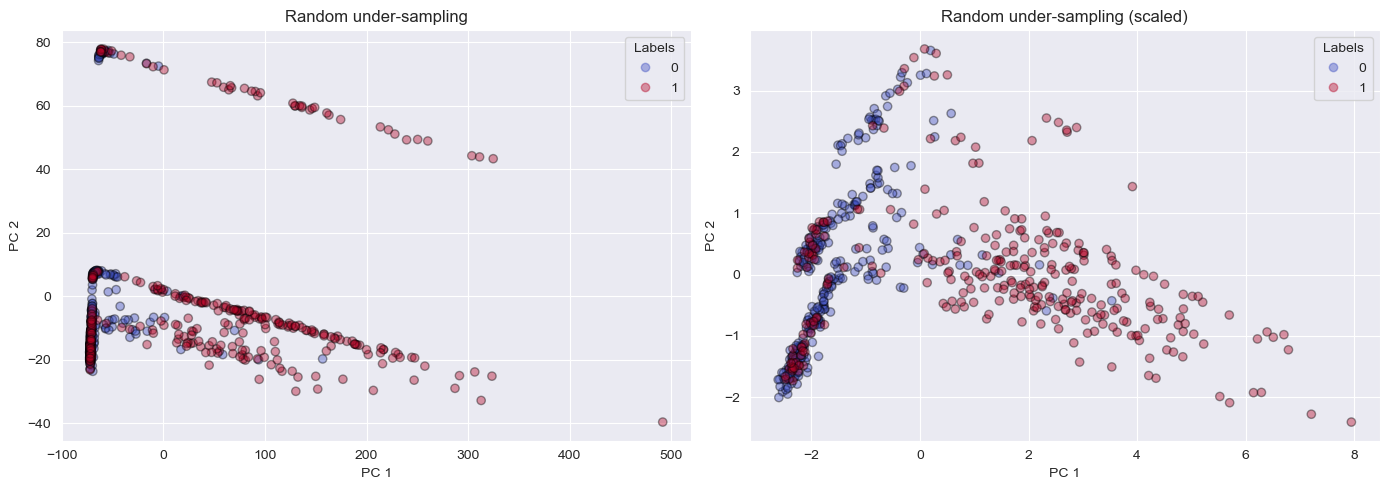

In [438]:
def plot_2d_space_normal(df, ax, title):
    X = df.drop(columns=['y'])
    y = df['y']

    # Performing PCA
    pca = PCA(n_components=2)  # 2 dimensions
    X_pca = pca.fit_transform(X)

    # Plot on the provided axis
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha = 0.4)  # k = black
    ax.set_title(title)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')

    handles, labels = scatter.legend_elements()
    ax.legend(handles, labels, title="Labels")

def plot_2d_space_scaled(df, ax, title):
    X = df.drop(columns=['y'])
    y = df['y']

    # Scaling the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Performing PCA on scaled data
    pca = PCA(n_components=2)  # 2 dimensions
    X_pca = pca.fit_transform(X_scaled)

    # Plot on the provided axis
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha = 0.4)  # k = black
    ax.set_title(title)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')

    handles, labels = scatter.legend_elements()
    ax.legend(handles, labels, title="Labels")

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot normal PCA
plot_2d_space_normal(df_rus, axs[0], title='Random under-sampling')

# Plot scaled PCA
plot_2d_space_scaled(df_rus, axs[1], title='Random under-sampling (scaled)')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [439]:
get_perf_table(X_rus, y_rus)

Accuracy for every fold : [0.84745763 0.86440678 0.89830508 0.76271186 0.79661017 0.81355932
 0.86440678 0.81355932 0.9137931  0.86206897]
Mean accuracy : 0.843687901811806
Standard deviation of accuracies : 0.04438162711272814

Confusion Matrix :
[[276  18]
 [ 74 220]] 

Accuracy for every fold : [0.86440678 0.86440678 0.91525424 0.76271186 0.83050847 0.79661017
 0.86440678 0.84745763 0.94827586 0.86206897]
Mean accuracy : 0.8556107539450613
Standard deviation of accuracies : 0.050225348799853894

Confusion Matrix :
[[283  11]
 [ 74 220]] 

Accuracy for every fold : [0.77966102 0.79661017 0.88135593 0.69491525 0.72881356 0.69491525
 0.81355932 0.69491525 0.79310345 0.74137931]
Mean accuracy : 0.7619228521332555
Standard deviation of accuracies : 0.05865917200083184

Confusion Matrix :
[[222  72]
 [ 68 226]] 

Optimal alpha : 0.006297996991343063
Accuracy for every fold : [0.84745763 0.86440678 0.91525424 0.76271186 0.83050847 0.83050847
 0.86440678 0.81355932 0.9137931  0.82758621]
Me

,model,accuracy,weighted error,AUC
0,Naive Bayes,0.843688,0.659864,0.843537
1,Logistic regression,0.855611,0.647959,0.855442
2,Decision Tree,0.761923,0.700680,0.761905
3,Decision Tree (optimal alpha),0.847019,0.663265,0.846939
4,Random Forest,0.829982,0.646259,0.829932
5,AdaBoost,0.845324,0.664966,0.845238


## Over-sampling

Random Oversampling dataset: (4468, 10)


Class 0: 2262
Class 1: 2206
Proportion of Class 0: 50.62667860340196
Proportion of Class 1: 49.37332139659804




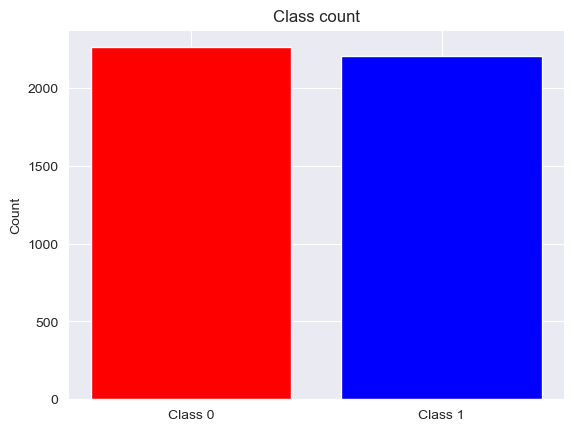

In [441]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

ros = ADASYN(random_state=42, sampling_strategy='auto') #'auto': equivalent to 'not majority'
X_ros, y_ros = ros.fit_resample(X, y_new)

print('Random Oversampling dataset:', X_ros.shape)
print('\n')
print('Class 0:', y_ros.count(0))
print('Class 1:', y_ros.count(1))
print('Proportion of Class 0:', (y_ros.count(0)/(y_ros.count(1)+y_ros.count(0)) * 100))
print('Proportion of Class 1:', 100 - (y_ros.count(0)/(y_ros.count(1)+y_ros.count(0)) * 100))
print("\n")
plt.bar(['Class 0', 'Class 1'], [y_ros.count(0), y_ros.count(1)], color=['red', 'blue'])
plt.title('Class count')
plt.ylabel('Count')
plt.show()

In [442]:
df_ros = X_ros.copy()
df_ros['y'] = y_ros

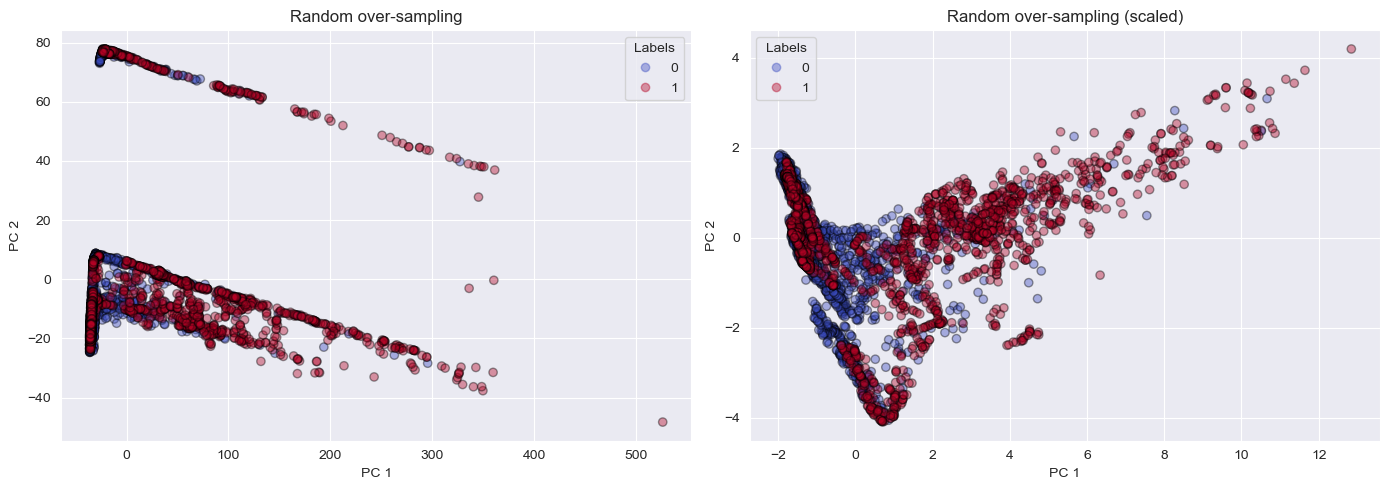

In [443]:
# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot normal PCA
plot_2d_space_normal(df_ros, axs[0], title='Random over-sampling')

# Plot scaled PCA
plot_2d_space_scaled(df_ros, axs[1], title='Random over-sampling (scaled)')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [444]:
get_perf_table(X_ros, y_ros)

Accuracy for every fold : [0.67561521 0.69127517 0.6689038  0.67337808 0.68456376 0.67114094
 0.70693512 0.71812081 0.6793722  0.70403587]
Mean accuracy : 0.687334095765492
Standard deviation of accuracies : 0.016222103802526724

Confusion Matrix :
[[2103  159]
 [1238  968]] 

Accuracy for every fold : [0.67337808 0.67337808 0.68903803 0.6689038  0.70022371 0.67785235
 0.68680089 0.73154362 0.71300448 0.69506726]
Mean accuracy : 0.6909190317111586
Standard deviation of accuracies : 0.018796769989034644

Confusion Matrix :
[[1976  286]
 [1095 1111]] 

Accuracy for every fold : [0.91946309 0.950783   0.91275168 0.93959732 0.92393736 0.93512304
 0.91946309 0.901566   0.91479821 0.92152466]
Mean accuracy : 0.9239007433713547
Standard deviation of accuracies : 0.01358679306408636

Confusion Matrix :
[[2056  206]
 [ 128 2078]] 

Optimal alpha : 0.00022086886868020545
Accuracy for every fold : [0.91722595 0.93736018 0.9082774  0.93959732 0.9261745  0.93512304
 0.91946309 0.9082774  0.9103139 

,model,accuracy,weighted error,AUC
0,Naive Bayes,0.687334,1.420994,0.684256
1,Logistic regression,0.690919,1.289391,0.688595
2,Decision Tree,0.923901,0.189346,0.925453
3,Decision Tree (optimal alpha),0.922782,0.204342,0.921186
4,Random Forest,0.959491,0.102283,0.959604
5,AdaBoost,0.807529,0.709042,0.806665


## Combine

In [446]:
from imblearn.combine import SMOTEENN

sme = SMOTEENN(random_state=42)
X_com, y_com = sme.fit_resample(X, y_new)

print('Combined dataset shape:', X_com.shape)

Combined dataset shape: (3745, 10)


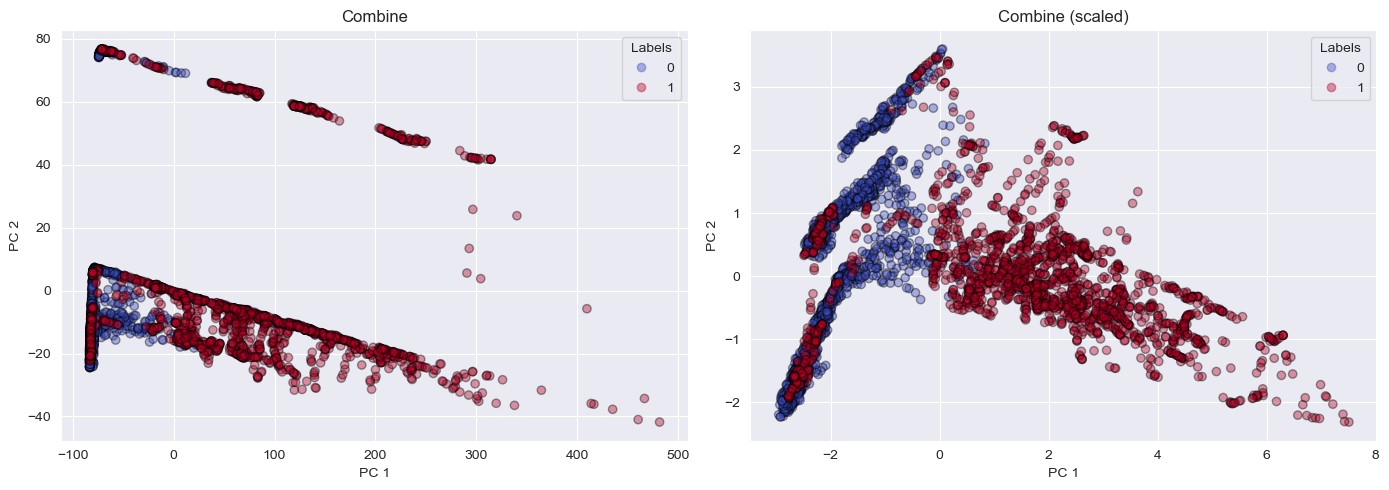

In [447]:
df_com = X_com.copy()
df_com['y'] = y_com

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot normal PCA
plot_2d_space_normal(df_com, axs[0], title='Combine')

# Plot scaled PCA
plot_2d_space_scaled(df_com, axs[1], title='Combine (scaled)')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Accuracy for every fold : [0.98133333 0.97866667 0.98133333 0.97866667 0.976      0.98663102
 0.98930481 0.97593583 0.98930481 0.97593583]
Mean accuracy : 0.9813112299465242
Standard deviation of accuracies : 0.0050604575162526404

Confusion Matrix :
[[1726   15]
 [  55 1949]] 

Weighted error : 0.0774365821094793 

Area under the Roc Curve (AUC) : 0.9819695760689993


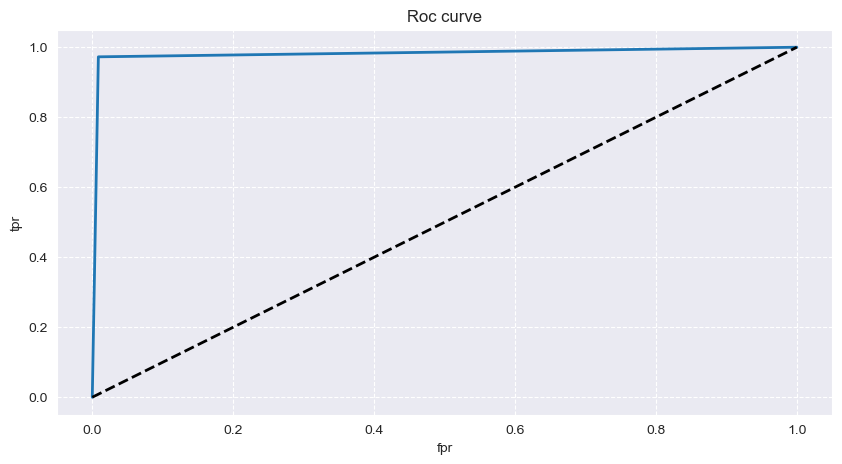

In [448]:
RF = RandomForestClassifier(n_estimators=100, random_state=seed)

kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

cv_scores = cross_val_score(RF, X_com, y_com, cv=kfold, scoring='accuracy')

print(f"Accuracy for every fold : {cv_scores}")
print(f"Mean accuracy : {cv_scores.mean()}")
print(f"Standard deviation of accuracies : {cv_scores.std()}\n")

y_pred = cross_val_predict(RF, X_com, y_com, cv=kfold)

conf_matrix = confusion_matrix(y_com, y_pred)
print("Confusion Matrix :")
print(conf_matrix, "\n")

werror = weighted_error(y_com, y_pred, 1, 5)
print("Weighted error :", werror, "\n")

fpr, tpr, thresholds= roc_curve(y_com, y_pred);
auc = roc_auc_score(y_com, y_pred)
print("Area under the Roc Curve (AUC) :", auc)

figure= plt.figure(figsize=(10,5));
plt.plot(fpr,tpr, linewidth= 2);
plt.title('Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed')
plt.show();

performance.loc[7, ["accuracy", "weighted error", "AUC"]] = [cv_scores.mean(), werror, auc]

In [449]:
get_perf_table(X_com, y_com)

Accuracy for every fold : [0.90133333 0.89866667 0.88266667 0.88       0.87733333 0.88770053
 0.89839572 0.87967914 0.87967914 0.90106952]
Mean accuracy : 0.8886524064171123
Standard deviation of accuracies : 0.009544463033798075

Confusion Matrix :
[[1643   98]
 [ 319 1685]] 

Accuracy for every fold : [0.912      0.90933333 0.92       0.90133333 0.896      0.9197861
 0.92513369 0.88770053 0.89037433 0.9144385 ]
Mean accuracy : 0.9076099821746881
Standard deviation of accuracies : 0.012431264093766426

Confusion Matrix :
[[1718   23]
 [ 323 1681]] 

Accuracy for every fold : [0.968      0.96266667 0.96533333 0.94933333 0.968      0.97593583
 0.98930481 0.97326203 0.97860963 0.95454545]
Mean accuracy : 0.9684991087344029
Standard deviation of accuracies : 0.011043818481220172

Confusion Matrix :
[[1672   69]
 [  55 1949]] 

Optimal alpha : 0.00026326181387389757
Accuracy for every fold : [0.97066667 0.96266667 0.96       0.96266667 0.968      0.97860963
 0.97058824 0.96791444 0.9705882

,model,accuracy,weighted error,AUC
0,Naive Bayes,0.888652,0.452069,0.892264
1,Logistic regression,0.907610,0.437383,0.912806
2,Decision Tree,0.968499,0.091856,0.966461
3,Decision Tree (optimal alpha),0.967427,0.091055,0.968509
4,Random Forest,0.981311,0.077437,0.981970
5,AdaBoost,0.928177,0.316422,0.931377
